# Occupancy Detection - UCI Data

# 1. Prepare the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import threading
import psutil
import time
import gc
import tsfresh
from scipy.stats import pearsonr
from datetime import datetime
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table

plt.style.use('seaborn')
%matplotlib inline  

In [2]:
class MemoryTracker():
    """
    The MemoryTracker measures the system's memory consumption
    once every second. It can be used to get an approximation of 
    the overall memory consumption of certain algorithms.
    """
    
    def __init__(self):
        self._initial_usage = 0
        self._max_usage = 0
        
        self._stop = False
        
        self.lock = threading.Lock()
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
    def __del__(self):
        self.stop()
        
    def _get_memory_usage(self):
        return psutil.virtual_memory().used

    def _measure_memory_usage(self):
        while True:
            time.sleep(1)
            
            self.lock.acquire()
                                    
            if self._stop:
                self.lock.release()
                break
            
            current_usage = self._get_memory_usage()
            
            if current_usage > self._max_usage:
                self._max_usage = current_usage
            
            self.lock.release()

    @property
    def peak_consumption(self):
        """
        The peak system memory consumption, in GB
        """
        self.lock.acquire()
        
        p_con = self._max_usage - self._initial_usage
        
        self.lock.release()
        
        p_con /= 1e9
        
        return p_con
    
    def start(self):
        """
        Starts measuring the memory consumption.
        """
        self.lock.acquire()
        
        self._initial_usage = self._get_memory_usage()
        
        self._max_usage = self._initial_usage
        
        self._stop = False
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
        self.th.start()
        
        self.lock.release()
        
    def stop(self):
        """
        Stops measuring the memory consumption.
        """
        self.lock.acquire()
        self._stop = True
        self.lock.release()

In [3]:
memory_tracker = MemoryTracker()

In [4]:
# import the dataset
training = pd.read_csv("datatraining.txt")
test = pd.read_csv("datatest.txt")
test_2 = pd.read_csv("datatest2.txt")

In [5]:
training

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


Let's create copies of our dataframes: One of each slice for every feature engineering solution we are going to use.
Those will be:
- Manual Feature Engineering with pandas
- Automated Feature Engineering with getML
- Automated Feature Engineering with tsfresh
- Automated Feature Engineering with featuretools

Each solution will return a single dataframe containing our feature enriched data, that we can use to train a classification model afterwards.

In [6]:
df_manual_training = training.copy()
df_manual_test = test.copy()
df_manual_test2 = test_2.copy()

df_getml_training = training.copy()
df_getml_test = test.copy()
df_getml_test2 = test_2.copy()

df_ts_training = training.copy()
df_ts_test = test.copy()
df_ts_test2 = test_2.copy()

df_ft_training = training.copy()
df_ft_test = test.copy()
df_ft_test2 = test_2.copy()

# 2. Manual Feature Engineering

In [7]:
for df in [df_manual_training, df_manual_test, df_manual_test2]:
    df['Humidity_lag_1'] = df['Humidity'].shift(1)
    df['Humidity_lag_5'] = df['Humidity'].shift(5)
    df['Humidity_lag_10'] = df['Humidity'].shift(10)
    df['Humidity_lag_30'] = df['Humidity'].shift(30)
    df['Humidity_lag_45'] = df['Humidity'].shift(45)
    df['Humidity_lag_60'] = df['Humidity'].shift(60)

    df['Temperature_lag_1'] = df['Temperature'].shift(1)
    df['Temperature_lag_5'] = df['Temperature'].shift(5)
    df['Temperature_lag_10'] = df['Temperature'].shift(10)
    df['Temperature_lag_30'] = df['Temperature'].shift(30)
    df['Temperature_lag_45'] = df['Temperature'].shift(45)
    df['Temperature_lag_60'] = df['Temperature'].shift(60)

    df['Light_lag_1'] = df['Light'].shift(1)
    df['Light_lag_5'] = df['Light'].shift(5)
    df['Light_lag_10'] = df['Light'].shift(10)
    df['Light_lag_30'] = df['Light'].shift(30)
    df['Light_lag_45'] = df['Light'].shift(45)
    df['Light_lag_60'] = df['Light'].shift(60)

    df['CO2_lag_1'] = df['CO2'].shift(1)
    df['CO2_lag_5'] = df['CO2'].shift(5)
    df['CO2_lag_10'] = df['CO2'].shift(10)
    df['CO2_lag_30'] = df['CO2'].shift(30)
    df['CO2_lag_45'] = df['CO2'].shift(45)
    df['CO2_lag_60'] = df['CO2'].shift(60) 
    df = df.dropna()

df_manual_training = df_manual_test.dropna()
df_manual_test = df_manual_test.dropna()
df_manual_test2 = df_manual_test2.dropna()

# 3. Feature Engineering with TSFresh

In [8]:
class TSFreshBuilder():
    
    def __init__(self, num_features, memory, column_id, time_stamp, target):
        """
        Scikit-learn style feature builder based on TSFresh.
        
        Args:
            
            num_features: The (maximum) number of features to build.
            
            memory: How much back in time you want to go until the
                    feature builder starts "forgetting" data.
                    
            column_id: The name of the column containing the ids.
            
            time_stamp: The name of the column containing the time stamps.
            
            target: The name of the target column.
        """
        self.num_features = num_features
        self.memory = memory
        self.column_id = column_id
        self.time_stamp = time_stamp
        self.target = target
        
        self.selected_features = []
        
    def _add_original_columns(self, original_df, df_selected):
        for colname in original_df.columns:
            df_selected[colname] = np.asarray(
                original_df[colname])
                    
        return df_selected

    def _extract_features(self, df):
        df_rolled = roll_time_series(
            df, 
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            max_timeshift=self.memory
        )
        
        extracted_minimal = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
        )
        
        extracted_index_based = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.settings.IndexBasedFCParameters()
        )
        
        extracted_features = pd.concat(
            [extracted_minimal, extracted_index_based], axis=1
        )
        del extracted_minimal
        del extracted_index_based
        
        gc.collect()
        
        extracted_features[
            extracted_features != extracted_features] = 0.0  
        
        extracted_features[
            np.isinf(extracted_features)] = 0.0 
        
        return extracted_features
        
    def _print_time_taken(self, begin, end):

        seconds = end - begin

        hours = int(seconds / 3600)
        seconds -= float(hours * 3600)

        minutes = int(seconds / 60)
        seconds -= float(minutes * 60)

        seconds = round(seconds, 6)

        print(
            "Time taken: " + str(hours) + "h:" +
            str(minutes) + "m:" + str(seconds)
        )

        print("")
        
    def _remove_target_column(self, df):
        colnames = np.asarray(df.columns)
        
        if self.target not in colnames:
            return df
        
        colnames = colnames[colnames != self.target]
        
        return df[colnames]
        
    def _select_features(self, df, target):
        df_selected = tsfresh.select_features(
            df, 
            target
        )
        
        colnames = np.asarray(df_selected.columns)

        correlations = np.asarray([
            np.abs(pearsonr(target, df_selected[col]))[0] for col in colnames
        ])
        
        # [::-1] is somewhat unintuitive syntax,
        # but it reverses the entire column.
        self.selected_features = colnames[
            np.argsort(correlations)
        ][::-1][:self.num_features]

        return df_selected[self.selected_features]
        
    def fit(self, df):
        """
        Fits the features.
        """
        begin = time.time()

        target = np.asarray(df[self.target])
        
        df_without_target = self._remove_target_column(df)
        
        df_extracted = self._extract_features(
            df_without_target)
        
        df_selected = self._select_features(
            df_extracted, target)
                
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)

        end = time.time()
        
        self._print_time_taken(begin, end)
        
        return df_selected
    
    def transform(self, df):
        """
        Transforms the raw data into a set of features.
        """
        df_extracted = self._extract_features(df)
        
        df_selected = df_extracted[self.selected_features]
        
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)
                                         
        return df_selected

In [9]:
tsfresh_builder = TSFreshBuilder(
    num_features=20,
    memory=30,
    column_id="id",
    time_stamp="date",
    target="Occupancy"
)

In [10]:
df_ts_training['id'] = 1
df_ts_test['id'] = 1
df_ts_test2['id'] = 1

In [11]:
memory_tracker.start()
start = time.time()
tsfresh_train_pandas = tsfresh_builder.fit(df_ts_training)
tsfresh_test_pandas = tsfresh_builder.transform(df_ts_test2)
memory_tracker.stop()
end = time.time()

print("Elapsed Time: ", (end - start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


Feature Extraction: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Time taken: 0h:0m:50.720615



Feature Extraction: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Elapsed Time:  120.3321099281311
Memory consumption: 
0.135892992


# 4. Feature Engineering with featuretools

In [12]:
df_ft_training = df_ft_training.reset_index()
df_ft_test2 = df_ft_test2.reset_index()

In [13]:
df_ft_test2

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1
...,...,...,...,...,...,...,...,...
9747,9748,2015-02-18 09:15:00,20.8150,27.717500,429.750000,1505.250000,0.004213,1
9748,9749,2015-02-18 09:16:00,20.8650,27.745000,423.500000,1514.500000,0.004230,1
9749,9750,2015-02-18 09:16:59,20.8900,27.745000,423.500000,1521.500000,0.004237,1
9750,9751,2015-02-18 09:17:59,20.8900,28.022500,418.750000,1632.000000,0.004279,1


In [14]:
peripheral_training = pd.DataFrame()
peripheral_test = pd.DataFrame()

memory_tracker.start()
start = time.time()

for index, row in df_ft_training.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = df_ft_training[(pd.to_datetime(df_ft_training['date']) > until) & (pd.to_datetime(df_ft_training['date']) < t)]
    to_add['join_key'] = int(row['index'])
    peripheral_training = peripheral_training.append(to_add)

for index, row in df_ft_test2.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = df_ft_test2[(pd.to_datetime(df_ft_test2['date']) > until) & (pd.to_datetime(df_ft_test2['date']) < t)]
    to_add['join_key'] = int(row['index'])
    peripheral_test = peripheral_test.append(to_add)
    
memory_tracker.stop()
end = time.time()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

print("Elapsed time: ")
print(end - start)

<ipython-input-14-d36b54460625>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['index'])
<ipython-input-14-d36b54460625>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['index'])


Memory consumption: 
0.180015104
Elapsed time: 
238.9465868473053


In [16]:
peripheral_test

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,join_key
0,1,2015-02-11 14:48:00,21.760,31.133333,437.333333,1029.666667,0.005021,1,2
0,1,2015-02-11 14:48:00,21.760,31.133333,437.333333,1029.666667,0.005021,1,3
1,2,2015-02-11 14:49:00,21.790,31.000000,437.333333,1000.000000,0.005009,1,3
0,1,2015-02-11 14:48:00,21.760,31.133333,437.333333,1029.666667,0.005021,1,4
1,2,2015-02-11 14:49:00,21.790,31.000000,437.333333,1000.000000,0.005009,1,4
...,...,...,...,...,...,...,...,...,...
9746,9747,2015-02-18 09:14:00,20.815,27.417500,430.750000,1511.750000,0.004167,1,9752
9747,9748,2015-02-18 09:15:00,20.815,27.717500,429.750000,1505.250000,0.004213,1,9752
9748,9749,2015-02-18 09:16:00,20.865,27.745000,423.500000,1514.500000,0.004230,1,9752
9749,9750,2015-02-18 09:16:59,20.890,27.745000,423.500000,1521.500000,0.004237,1,9752


In [17]:
peripheral_training.drop(['Occupancy', 'index'], axis=1, inplace=True)
peripheral_test.drop(['Occupancy', 'index'], axis=1, inplace=True)

In [18]:
peripheral_training = peripheral_training.reset_index()

In [19]:
peripheral_training

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,join_key
0,0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,2
1,0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,3
2,1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,3
3,0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,4
4,1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,4
...,...,...,...,...,...,...,...,...
237871,8137,2015-02-10 09:28:00,21.05,36.0500,433.0,780.250000,0.005571,8143
237872,8138,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,8143
237873,8139,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,8143
237874,8140,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,8143


In [20]:
peripheral_training.drop(['index'], axis=1, inplace=True)
peripheral_training = peripheral_training.reset_index()
peripheral_training

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,join_key
0,0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,2
1,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,3
2,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,3
3,3,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,4
4,4,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,4
...,...,...,...,...,...,...,...,...
237871,237871,2015-02-10 09:28:00,21.05,36.0500,433.0,780.250000,0.005571,8143
237872,237872,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,8143
237873,237873,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,8143
237874,237874,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,8143


In [21]:
df_ft_training

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...,...
8138,8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8139,8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8140,8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8141,8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [22]:
import featuretools as ft
es = ft.EntitySet(id="occupancy_detection")
es = es.entity_from_dataframe(entity_id="population",
                              dataframe=df_ft_training,
                              time_index="date",
                              index="index")

es = es.entity_from_dataframe(entity_id="peripheral",
                             dataframe=peripheral_training,
                             index='index')

self_join = ft.Relationship(es["population"]["index"],
                            es["peripheral"]["join_key"])

es = es.add_relationship(self_join)

es


Entityset: occupancy_detection
  Entities:
    population [Rows: 8143, Columns: 8]
    peripheral [Rows: 237876, Columns: 8]
  Relationships:
    peripheral.join_key -> population.index

In [23]:
memory_tracker.start()
start=time.time()
features, feature_names = ft.dfs(entityset=es, target_entity='population', 
                                 max_depth = 2)
end = time.time()
memory_tracker.stop()

print("Elapsed Time: ", (end-start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


features = features.dropna()
features

Elapsed Time:  11.678423881530762
Memory consumption: 
0.020942848


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,COUNT(peripheral),MAX(peripheral.CO2),MAX(peripheral.Humidity),MAX(peripheral.HumidityRatio),...,WEEKDAY(date),YEAR(date),MODE(peripheral.DAY(date)),MODE(peripheral.MONTH(date)),MODE(peripheral.WEEKDAY(date)),MODE(peripheral.YEAR(date)),NUM_UNIQUE(peripheral.DAY(date)),NUM_UNIQUE(peripheral.MONTH(date)),NUM_UNIQUE(peripheral.WEEKDAY(date)),NUM_UNIQUE(peripheral.YEAR(date))
index,,,,,,,,,,,,,,,,,,,,,
4,23.15,27.2000,426.0,708.250000,0.004772,1,3.0,721.250000,27.2720,0.004793,...,2,2015,4.0,2.0,2.0,2015.0,1.0,1.0,1.0,1.0
5,23.10,27.2000,426.0,704.500000,0.004757,1,4.0,721.250000,27.2720,0.004793,...,2,2015,4.0,2.0,2.0,2015.0,1.0,1.0,1.0,1.0
6,23.10,27.2000,419.0,701.000000,0.004757,1,5.0,721.250000,27.2720,0.004793,...,2,2015,4.0,2.0,2.0,2015.0,1.0,1.0,1.0,1.0
7,23.10,27.2000,419.0,701.666667,0.004757,1,6.0,721.250000,27.2720,0.004793,...,2,2015,4.0,2.0,2.0,2015.0,1.0,1.0,1.0,1.0
8,23.10,27.2000,419.0,699.000000,0.004757,1,7.0,721.250000,27.2720,0.004793,...,2,2015,4.0,2.0,2.0,2015.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,21.05,36.0975,433.0,787.250000,0.005579,1,29.0,780.250000,36.0500,0.005571,...,1,2015,10.0,2.0,1.0,2015.0,1.0,1.0,1.0,1.0
8140,21.05,35.9950,433.0,789.500000,0.005563,1,30.0,787.250000,36.0975,0.005579,...,1,2015,10.0,2.0,1.0,2015.0,1.0,1.0,1.0,1.0
8141,21.10,36.0950,433.0,798.500000,0.005596,1,30.0,789.500000,36.0975,0.005579,...,1,2015,10.0,2.0,1.0,2015.0,1.0,1.0,1.0,1.0


In [24]:
feature_matrix_enc, features_enc = ft.encode_features(features, feature_names, include_unknown=False)

In [25]:
featuretools_training = feature_matrix_enc.copy()

In [26]:
df_ft_test2

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1
...,...,...,...,...,...,...,...,...
9747,9748,2015-02-18 09:15:00,20.8150,27.717500,429.750000,1505.250000,0.004213,1
9748,9749,2015-02-18 09:16:00,20.8650,27.745000,423.500000,1514.500000,0.004230,1
9749,9750,2015-02-18 09:16:59,20.8900,27.745000,423.500000,1521.500000,0.004237,1
9750,9751,2015-02-18 09:17:59,20.8900,28.022500,418.750000,1632.000000,0.004279,1


In [27]:
# creating and entity set 'es'
es_tst = ft.EntitySet(id = 'occupancy')
# adding a dataframe 
es_tst = es_tst.entity_from_dataframe(entity_id='population', 
                             dataframe=df_ft_test2,
                             time_index='date',
                             index = 'index')
es_tst = es_tst.entity_from_dataframe(entity_id='peripheral',
                             dataframe=peripheral_test,
                             index='index')
es_tst

/usr/local/lib/python3.8/site-packages/featuretools/entityset/entity.py:610: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: occupancy
  Entities:
    population [Rows: 9752, Columns: 8]
    peripheral [Rows: 284966, Columns: 8]
  Relationships:
    No relationships

In [28]:
self_join = ft.Relationship(es_tst["population"]["index"],
                            es_tst["peripheral"]["join_key"])
es_tst = es_tst.add_relationship(self_join)

es_tst



Entityset: occupancy
  Entities:
    population [Rows: 9752, Columns: 8]
    peripheral [Rows: 284966, Columns: 8]
  Relationships:
    peripheral.join_key -> population.index

In [29]:
feature_matrix_tst = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)

In [30]:
feature_matrix_tst = feature_matrix_tst.dropna()

# 5. Feature Engineering with getML

In [53]:
import getml

getml.engine.set_project('occupancy_detection_uci')

Loading existing project 'occupancy_detection_uci'


In [54]:
train_getml = getml.data.DataFrame.from_pandas(df_getml_training, "getml_training")
test_getml = getml.data.DataFrame.from_pandas(df_getml_test2, "getml_test")

Name,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,date
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,21.76,31.1333,437.333,1029.67,0.00502101,1,2015-02-11 14:48:00
1,21.79,31,437.333,1000,0.00500858,1,2015-02-11 14:49:00
2,21.7675,31.1225,434,1003.75,0.00502157,1,2015-02-11 14:50:00
3,21.7675,31.1225,439,1009.5,0.00502157,1,2015-02-11 14:51:00
4,21.79,31.1333,437.333,1005.67,0.0050303,1,2015-02-11 14:51:59
,...,...,...,...,...,...,...
9747,20.815,27.7175,429.75,1505.25,0.00421297,1,2015-02-18 09:15:00
9748,20.865,27.745,423.5,1514.5,0.00423026,1,2015-02-18 09:16:00
9749,20.89,27.745,423.5,1521.5,0.00423682,1,2015-02-18 09:16:59


In [56]:
for df in [train_getml, test_getml]:
    df.set_role("Occupancy", getml.data.roles.target)
    df.set_role("date", getml.data.roles.time_stamp)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [57]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

population.join(
    peripheral,
    time_stamp='date',
    memory=getml.data.time.minutes(30)
)

population

placeholder   other placeholder   allow lagged targets   horizon   
population    peripheral          False                  0.0       



join keys used   memory   other join keys used   other time stamps used   
                 1800.0                          date                     



join keys used   relationship   time stamps used   ...   
                 many-to-many   date               ...

In [58]:
multirel = getml.feature_learning.MultirelTimeSeries(
    ts_name="date",
    horizon=0.0,
    memory=getml.data.time.minutes(30),
    allow_lagged_targets=False,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_features=20
)

#relboost = getml.feature_learning.RelboostTimeSeries(
#    ts_name="date",
#    horizon=0.0,
#    memory=getml.data.time.minutes(30),
#    allow_lagged_targets=False,
#    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
#    num_features=10
#)

predictor = getml.predictors.LogisticRegression()

In [59]:
seasonal=getml.preprocessors.Seasonal()

pipe = getml.pipeline.Pipeline(
    tags=['memory: 30min', 'horizon: 0'],
    population=population,
    peripheral=[peripheral],
    feature_learners=[multirel],
    predictors=[predictor],
    preprocessors=[seasonal]
)

In [60]:
pipe.check(train_getml, [train_getml])

Checking data model...
OK.


In [61]:
start = time.time()
memory_tracker.start()
pipe.fit(train_getml, [train_getml])
memory_tracker.stop()
end = time.time()

print("Elapsed Time: ", (end-start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

Checking data model...
OK.

Multirel: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:3m:15.447851

Elapsed Time:  195.98465609550476
Memory consumption: 
0.012115968


In [62]:
#getml_train_df = pipe.transform(train_getml,[train_getml],df_name="getml_train")
#getml_test_df = pipe.transform(test_getml, [test_getml],df_name="getml_test")

# 6. Predictive Modelling

For this step we are going to use the getML Predictors. Initally all our feature-enriched training and test data for each feature engineering solution is available as a pandas dataframe.

In [63]:
train_manual = getml.data.DataFrame.from_pandas(df_manual_training, "manual_training")
test_manual = getml.data.DataFrame.from_pandas(df_manual_test2, "manual_test")

In [64]:
train_tsfresh = getml.data.DataFrame.from_pandas(tsfresh_train_pandas, "tsfresh_training")
test_tsfresh = getml.data.DataFrame.from_pandas(tsfresh_test_pandas, "tsfresh_test")

In [65]:
train_ft = getml.data.DataFrame.from_pandas(feature_matrix_enc, "ft_training")
test_ft = getml.data.DataFrame.from_pandas(feature_matrix_tst, "ft_test")

In [66]:
test_ft

Name,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,COUNT(peripheral),MAX(peripheral.CO2),MAX(peripheral.Humidity),MAX(peripheral.HumidityRatio),MAX(peripheral.Light),MAX(peripheral.Temperature),MEAN(peripheral.CO2),MEAN(peripheral.Humidity),MEAN(peripheral.HumidityRatio),MEAN(peripheral.Light),MEAN(peripheral.Temperature),MIN(peripheral.CO2),MIN(peripheral.Humidity),MIN(peripheral.HumidityRatio),MIN(peripheral.Light),MIN(peripheral.Temperature),SKEW(peripheral.CO2),SKEW(peripheral.Humidity),SKEW(peripheral.HumidityRatio),SKEW(peripheral.Light),SKEW(peripheral.Temperature),STD(peripheral.CO2),STD(peripheral.Humidity),STD(peripheral.HumidityRatio),STD(peripheral.Light),STD(peripheral.Temperature),SUM(peripheral.CO2),SUM(peripheral.Humidity),SUM(peripheral.HumidityRatio),SUM(peripheral.Light),SUM(peripheral.Temperature),NUM_UNIQUE(peripheral.DAY(date)),NUM_UNIQUE(peripheral.MONTH(date)),NUM_UNIQUE(peripheral.WEEKDAY(date)),NUM_UNIQUE(peripheral.YEAR(date)),DAY(date) = 9,DAY(date) = 8,DAY(date) = 7,DAY(date) = 6,DAY(date) = 5,DAY(date) = 10,DAY(date) = 4,MONTH(date) = 2,WEEKDAY(date) = 6,WEEKDAY(date) = 5,WEEKDAY(date) = 4,WEEKDAY(date) = 3,WEEKDAY(date) = 0,WEEKDAY(date) = 1,WEEKDAY(date) = 2,YEAR(date) = 2015,MODE(peripheral.DAY(date)) = 9.0,MODE(peripheral.DAY(date)) = 8.0,MODE(peripheral.DAY(date)) = 7.0,MODE(peripheral.DAY(date)) = 6.0,MODE(peripheral.DAY(date)) = 5.0,MODE(peripheral.DAY(date)) = 10.0,MODE(peripheral.DAY(date)) = 4.0,MODE(peripheral.MONTH(date)) = 2.0,MODE(peripheral.WEEKDAY(date)) = 6.0,MODE(peripheral.WEEKDAY(date)) = 5.0,MODE(peripheral.WEEKDAY(date)) = 4.0,MODE(peripheral.WEEKDAY(date)) = 3.0,MODE(peripheral.WEEKDAY(date)) = 0.0,MODE(peripheral.WEEKDAY(date)) = 1.0,MODE(peripheral.WEEKDAY(date)) = 2.0,MODE(peripheral.YEAR(date)) = 2015.0
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,21.7675,31.1225,439,1009.5,0.00502157,1,3,1029.67,31.1333,0.00502157,437.333,21.79,1011.14,31.0853,0.00501705,436.222,21.7725,1000,31,0.00500858,434,21.76,1.62764,-1.69044,0,-1.73205,1.29334,16.1547,0.0740511,7.3427e-06,1.9245,0.0156125,3033.42,93.2558,0.0150512,1308.67,65.3175,1,1,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True
1,21.79,31.1333,437.333,1005.67,0.0050303,1,4,1029.67,31.1333,0.00502157,439,21.79,1010.73,31.0946,0.00501818,436.917,21.7712,1000,31,0.00500858,434,21.76,1.50613,-1.96025,0,-1.12934,1.5396,13.2157,0.063262,6.4063e-06,2.09718,0.0129904,4042.92,124.378,0.0200727,1747.67,87.085,1,1,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True
2,21.76,31.26,437.333,1014.33,0.0050416,1,5,1029.67,31.1333,0.0050303,439,21.79,1009.72,31.1023,0.00502061,437,21.775,1000,31,0.00500858,434,21.76,1.76943,-2.18655,0,-1.29323,0.381802,11.6669,0.0574619,7.75474e-06,1.82574,0.0140312,5048.58,155.512,0.025103,2185,108.875

In [67]:
for df in [train_manual, test_manual, train_tsfresh, test_tsfresh]:
    df.set_role("Occupancy", getml.data.roles.target)
    df.set_role("date", getml.data.roles.time_stamp)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [68]:
for df in [train_ft, test_ft]:
    df.set_role("Occupancy", getml.data.roles.target)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [69]:
predictor = getml.predictors.LogisticRegression()
seasonal = getml.preprocessors.Seasonal()
feature_selector = getml.predictors.LogisticRegression()

pipe_manual = getml.pipeline.Pipeline(
    tags=['manual'],
    predictors=[predictor],
    preprocessors=[seasonal]
)

pipe_tsfresh = getml.pipeline.Pipeline(
    tags=['tsfresh'],
    predictors=[predictor],
    preprocessors=[seasonal]
)

pipe_ft = getml.pipeline.Pipeline(
    tags=['featuretools'],
    predictors=[predictor],
    feature_selectors=feature_selector,
    share_selected_features=0.6,
    preprocessors=[seasonal]
)

In [70]:
pipe_manual.fit(train_manual)
pipe_tsfresh.fit(train_tsfresh)
pipe_ft.fit(train_ft)

Checking data model...
OK.

LogisticRegression: Training as predictor...


WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'id' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').




Trained pipeline.
Time taken: 0h:0m:0.100033

Checking data model...

LogisticRegression: Training as predictor...


WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'NUM_UNIQUE(peripheral.MONTH(date))' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'NUM_UNIQUE(peripheral.YEAR(date))' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').




Trained pipeline.
Time taken: 0h:0m:0.243128

Checking data model...

LogisticRegression: Training as feature selector...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.620302



Pipeline(preprocessors=['Seasonal'], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.6)

url: http://localhost:1709/getpipeline/Lz4xet/0/

In [72]:
score_manual_train = pipe_manual.score(train_manual)
score_manual_test = pipe_manual.score(test_manual)

score_tsfresh_train = pipe_tsfresh.score(train_tsfresh)
score_tsfresh_test = pipe_tsfresh.score(test_tsfresh)

score_ft_train = pipe_ft.score(train_ft)
score_ft_test = pipe_ft.score(test_ft)

score_getml_train = pipe.score(train_getml, [train_getml])
score_getml_test = pipe.score(test_getml, [test_getml])








Multirel: Building features...
[========================================] 100%


Multirel: Building features...
[========================================] 100%



In [73]:
score_manual_train

{'accuracy': [0.9854126679462571],
 'auc': [0.9971606511849954],
 'cross_entropy': [0.04968614940780228]}

In [74]:
score_manual_test

{'accuracy': [0.9601733388361535],
 'auc': [0.9755704310749705],
 'cross_entropy': [-1]}

In [75]:
score_tsfresh_train

{'accuracy': [0.9920176839002824],
 'auc': [0.9989879895103883],
 'cross_entropy': [0.027383002355364915]}

In [76]:
score_tsfresh_test

{'accuracy': [0.9365258408531584],
 'auc': [0.9614430865450118],
 'cross_entropy': [0.23628501641165348]}

In [77]:
score_ft_train

{'accuracy': [0.9925061425061426],
 'auc': [0.9989150507598364],
 'cross_entropy': [0.027356595847225905]}

In [78]:
score_ft_test

{'accuracy': [0.9744589188634731],
 'auc': [0.988464524047663],
 'cross_entropy': [0.10057480586055823]}

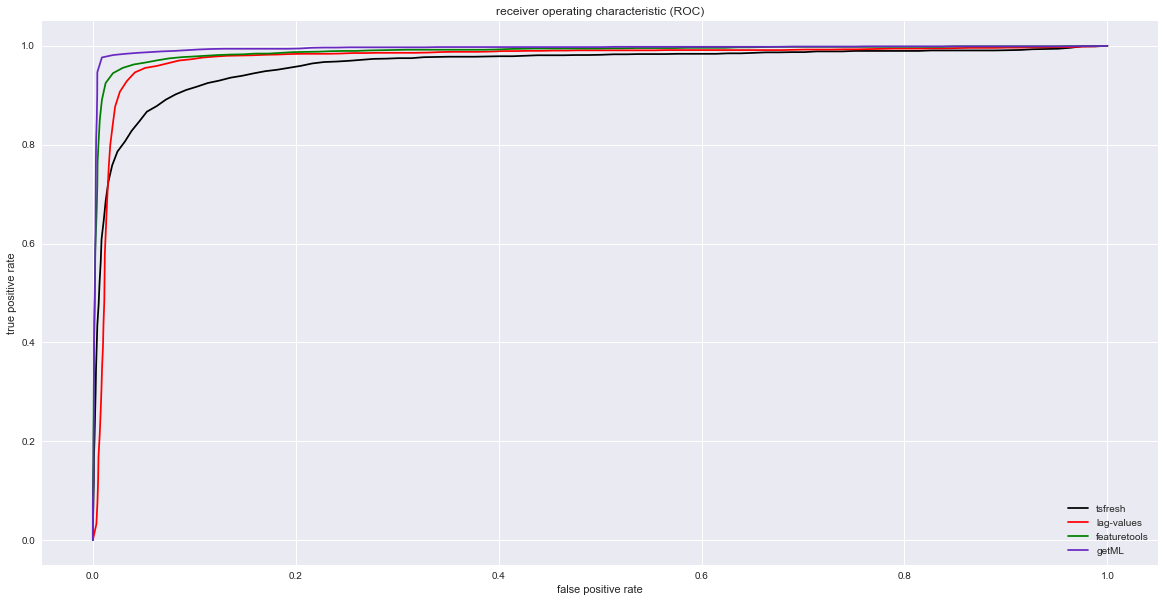

In [79]:
fpr_m, tpr_m = pipe_manual.metrics.roc_curve()
fpr_t, tpr_t = pipe_tsfresh.metrics.roc_curve()
fpr_f, tpr_f = pipe_ft.metrics.roc_curve()
fpr_g, tpr_g = pipe.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_t, tpr_t, color='black', label='tsfresh')
plt.plot(fpr_m, tpr_m, color='red', label='lag-values')
plt.plot(fpr_f, tpr_f, color='green', label='featuretools')
plt.plot(fpr_g, tpr_g, color='#6829c2', label='getML')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.legend(loc="lower right")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

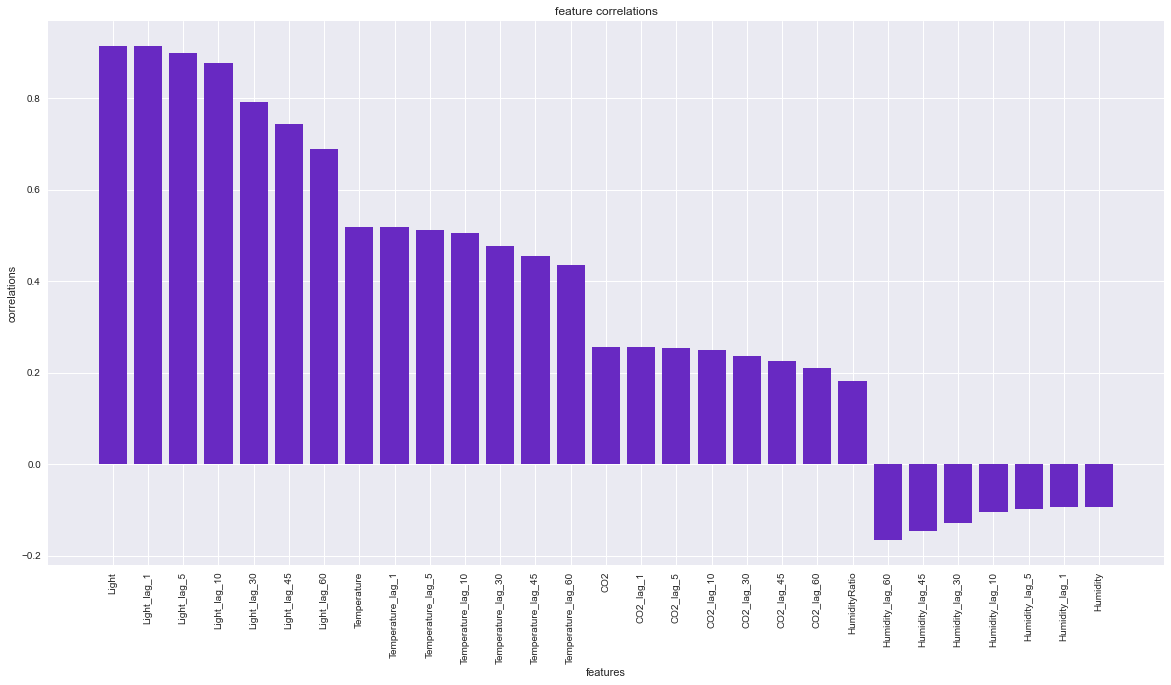

In [80]:
names, correlations = pipe_manual.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

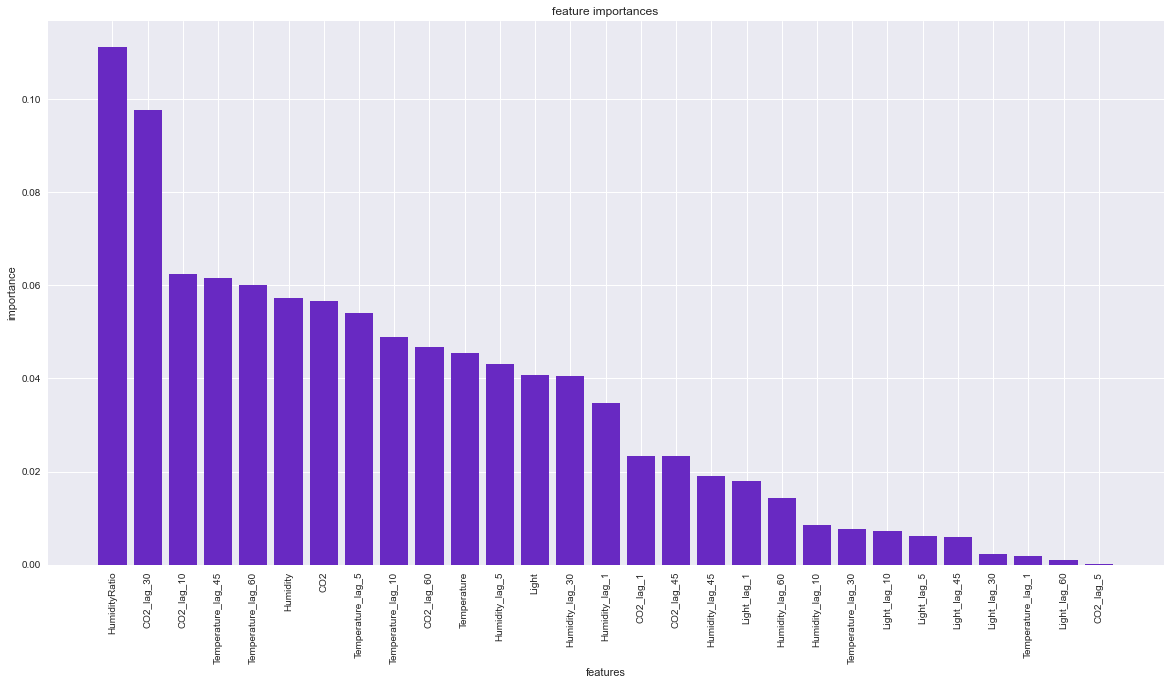

In [81]:
names, importances = pipe_manual.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

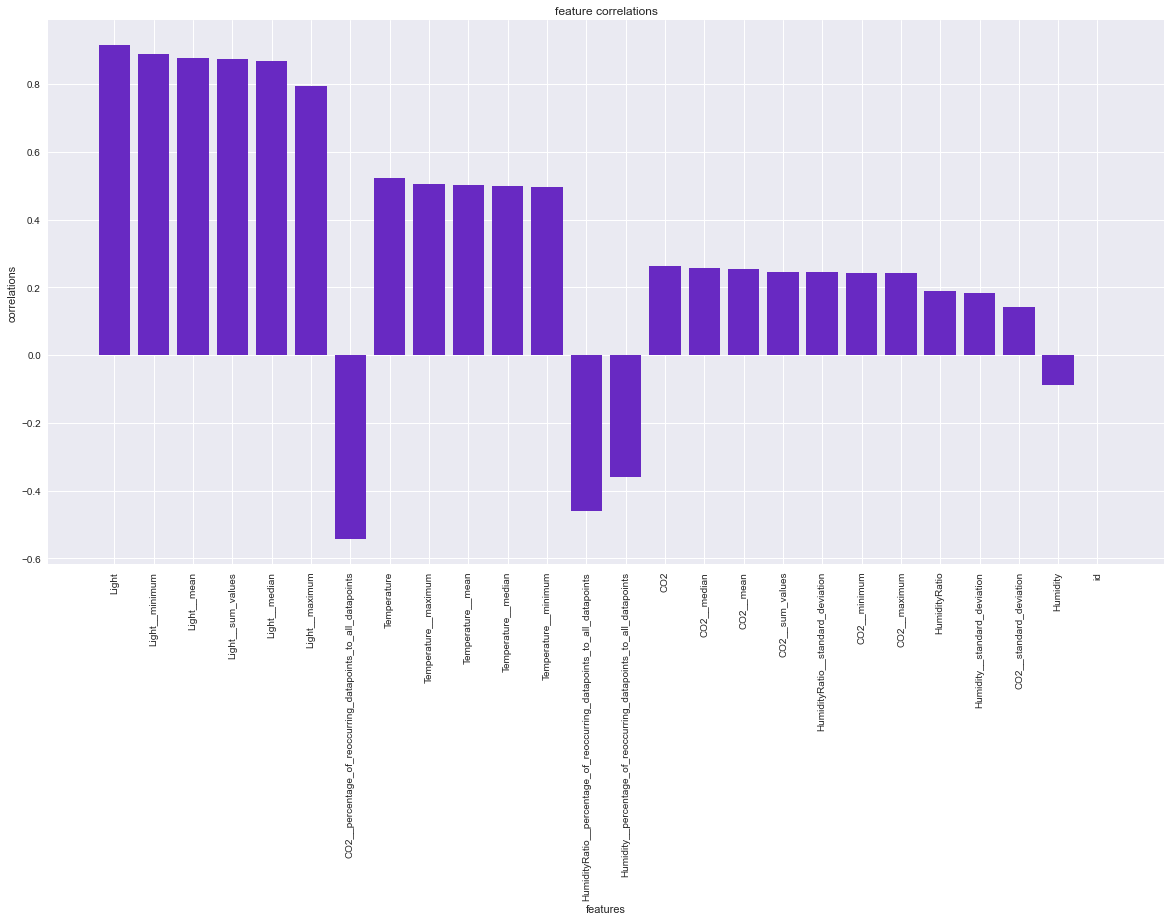

In [90]:
names, correlations = pipe_tsfresh.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

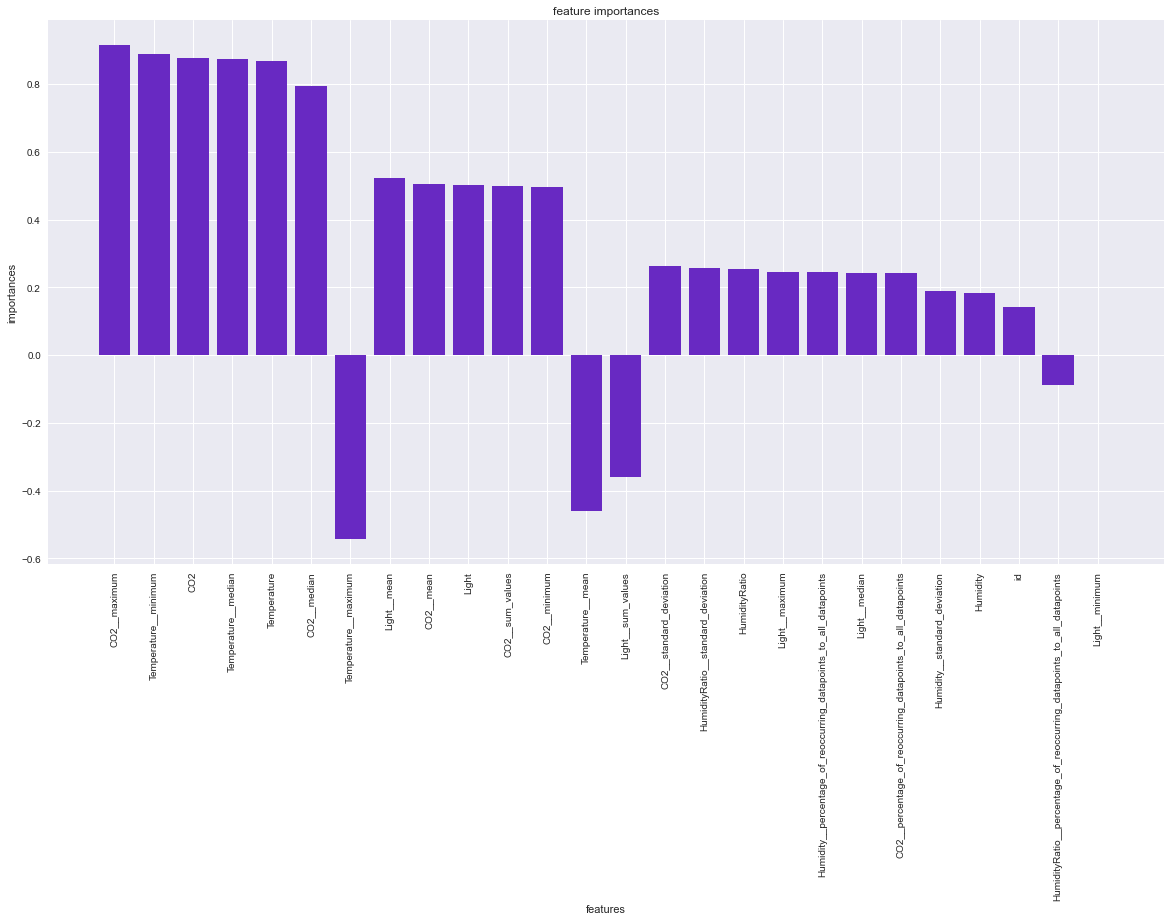

In [91]:
names, importances = pipe_tsfresh.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importances")
plt.xticks(rotation='vertical')

plt.show()

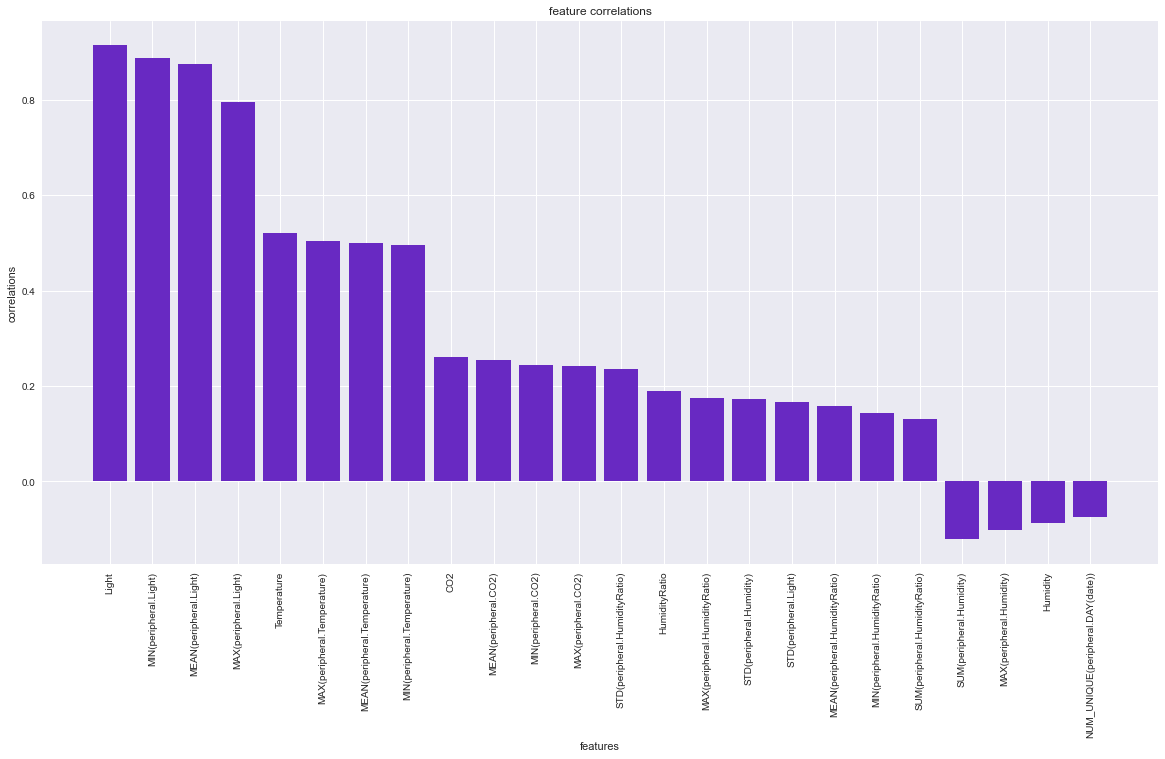

In [92]:
names, correlations = pipe_ft.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

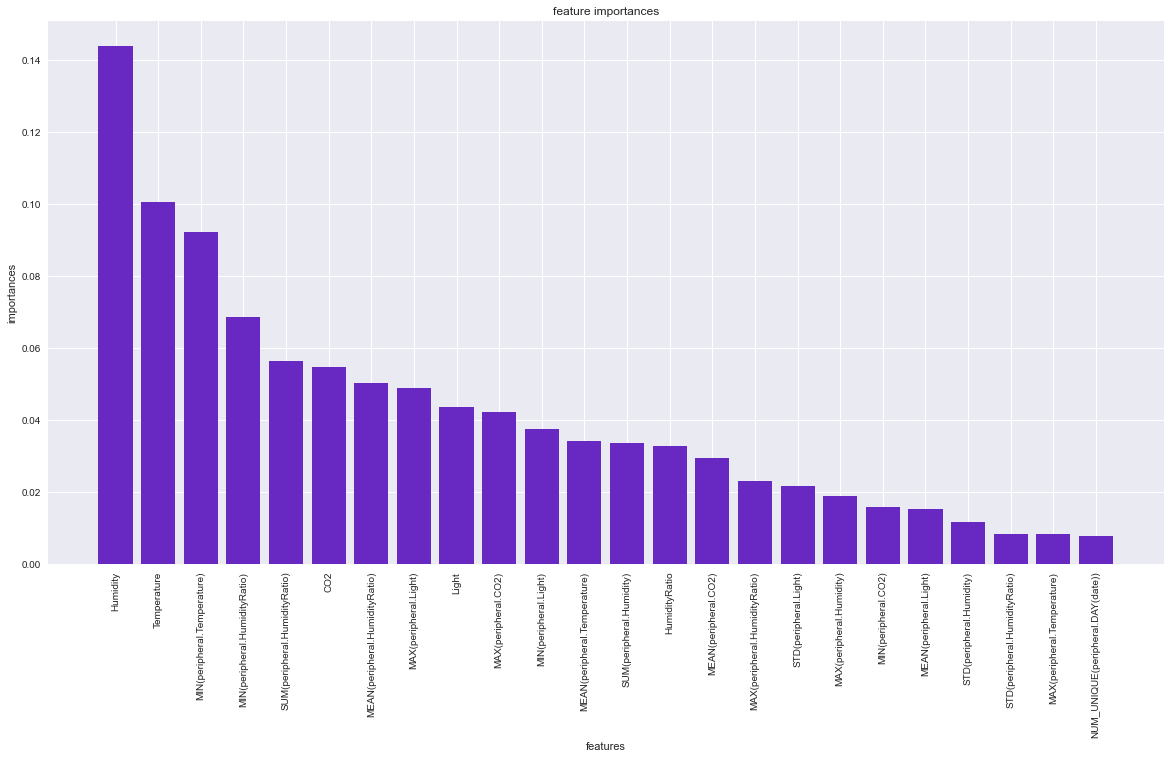

In [93]:
names, correlations = pipe_ft.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importances")
plt.xticks(rotation='vertical')

plt.show()

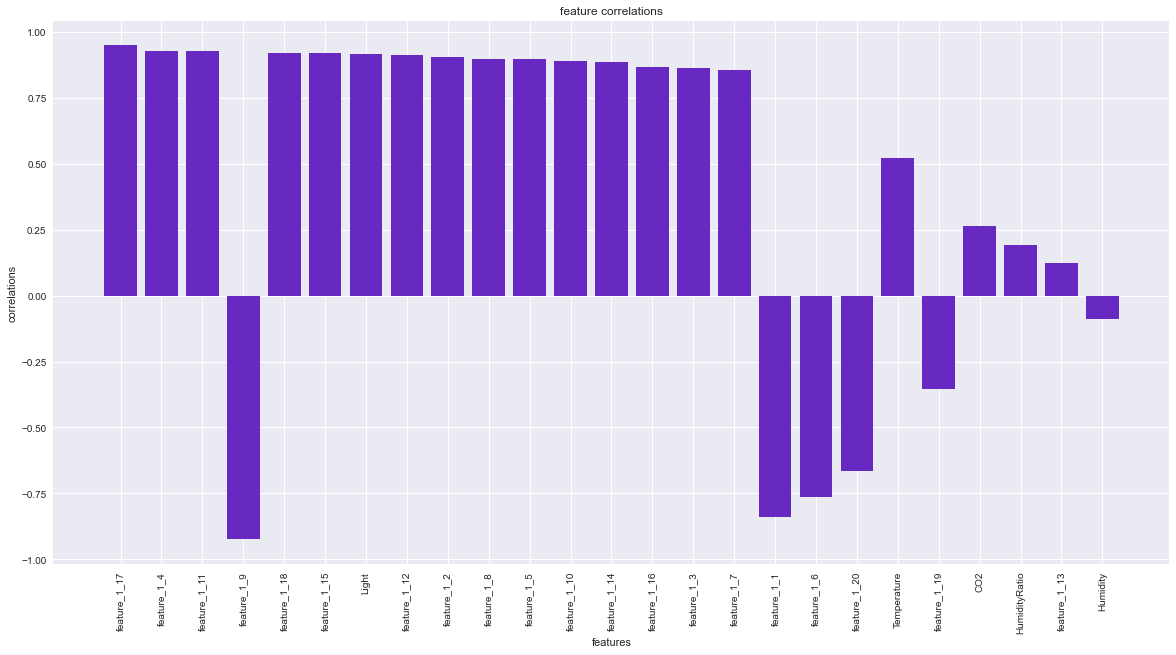

In [86]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

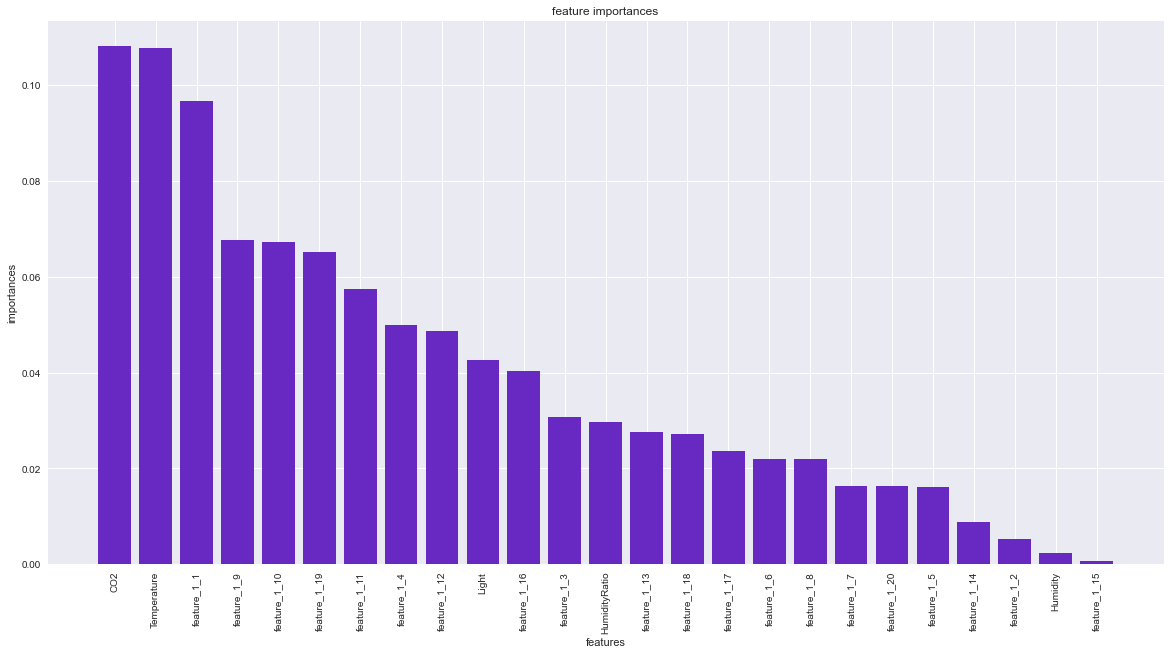

In [87]:
names, correlations = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importances")
plt.xticks(rotation='vertical')

plt.show()

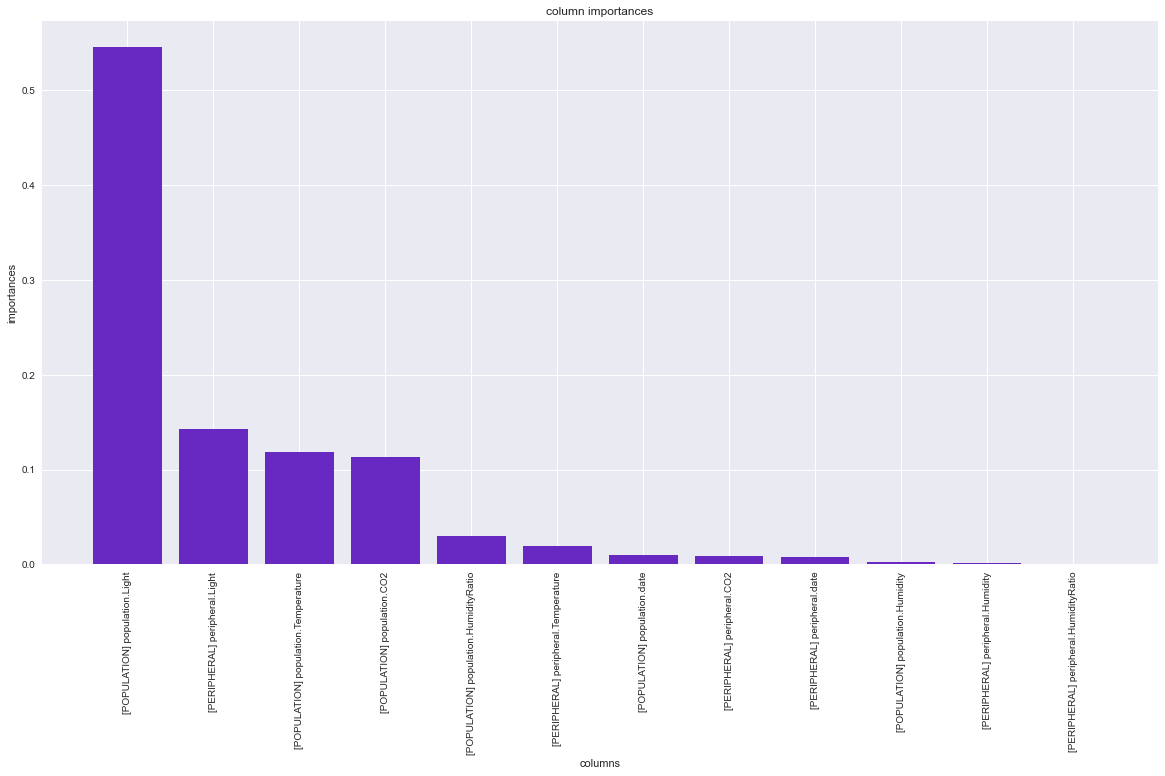

In [94]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importances")
plt.xticks(rotation='vertical')

plt.show()

In [88]:
pipe.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT AVG( ( julianday( t1."date" ) - julianday( t2."date" ) ) * 86400.0 ) AS "feature_1_1",
       t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral" t2
ON 1 = 1
WHERE ( julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
) AND (
   ( ( t1."Light" > 386.620087 OR t1."Light" IS NULL  ) AND ( t1."Temperature" > 22.671226 ) AND ( strftime('%M', t2."date" ) IN ( '17', '19', '20', '21', '22', '23', '07', '08', '10', '11', '13', '14', '15', '16', '40', '42', '43', '45', '46', '47', '48', '49' ) ) AND ( julianday( t1."date" ) > julianday( t2."date", '+15.111111 minutes' ) ) )
OR ( ( t1."Light" > 386.620087 OR t1."Light" IS NULL  ) AND ( t1."Temperature" <= 22.671226 OR t1."Temperature" IS NULL  ) AND ( t1."Temperature" > 19.584048 OR t1."Temperature" IS NULL  ) AND ( t1."CO2" <= 457.107143 ) )
OR ( ( t1."Light" > 386.620087 OR t1."Light" IS NULL  ) AND ( t1."Temperature" <= 22.671226 OR t1."Temperature" IS NULL  ) AND ( t1."Temperature" <= 19.584048 ) AND ( strftime('%M', t1."date" ) NOT IN ( '51' ) ) )
OR ( ( t1."Light" <= 386.620087 ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+19.939655 minutes' ) ) AND ( julianday( t1."date" ) > julianday( t2."date", '+18.094646 minutes' ) ) )
)
GROUP BY t1.rowid;
```